# IMPORTING AND FILTERING THE NEWS

In [ ]:
!pip install -U spacy
!pip install -U spacy-transformers
!python -m spacy download en_core_web_trf

In [2]:
import pandas as pd
import spacy
import pickle
import re

# Load the transformer model
nlp = spacy.load("en_core_web_trf")


file_path = '/Users/aakarshsurendra/Desktop/ROAD_NLP/02_dataset/data_road.csv'

dataframe = pd.read_csv(file_path)


/Users/aakarshsurendra/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/aakarshsurendra/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [32]:
!python -m spacy validate

/Users/aakarshsurendra/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.7.4) =================
ℹ spaCy installation:
/Users/aakarshsurendra/anaconda3/lib/python3.11/site-packages/spacy

NAME              SPACY            VERSION                            
en_core_web_sm    >=3.7.2,<3.8.0   3.7.1   ✔
en_core_web_lg    >=3.7.2,<3.8.0   3.7.1   ✔
en_core_web_trf   >=3.7.2,<3.8.0   3.7.3   ✔



### EXTRACTING PLACE OF ACCIDENT

In [15]:
places = dataframe['content'].str.split(':').str[0].str.strip()
dataframe['place'] = places

### CREATING IDs FOR EACH NEWS

In [16]:
# Function to extract id from link
def extract_id(link):
    match = re.search(r'\b(\d{6,11})\b', link)
    if match:
        return match.group(1)
    else:
        return None

# Apply the function to extract ids
dataframe['id'] = dataframe['Link'].apply(extract_id)
order = ['id','Link','content','News_date','place']
dataframe = dataframe[order]

## TEXT PRE-PROCESSING FUNCTION

In [ ]:
# Function to preprocess text using SpaCy
def preprocess_text_spacy(text):
    # Tokenize text and remove stopwords, punctuation, and lemmatize tokens
    doc = nlp(text)
    processed_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return processed_tokens

# STAGE I CLUSTERING

## DO NOT RUN

#### Run only once and store the output TF-IDF vector file as pickle -

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Complete data (list of article texts)
article_texts = dataframe.content

# Handling NaN values by replacing them with empty strings
article_texts_cleaned = article_texts.fillna('')

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=preprocess_text_spacy)

# Fit and transform the data
tfidf_matrix = tfidf_vectorizer.fit_transform(dataframe)

#### Exporting the pickle file

# Specify the file path where you want to save the TF-IDF matrix
file_path = "tfidf_matrix.pkl"

# Save the TF-IDF matrix to a file
with open(file_path, 'wb') as f:
    pickle.dump(tfidf_matrix, f)

## Load Pickle

#### Importing the pickle file - Run this

In [ ]:
# Specify the file path where the TF-IDF matrix is saved
file_path = "/Users/aakarshsurendra/Desktop/ROAD_NLP/07_pickle_files/tfidf_matrix.pkl"

# Load the TF-IDF matrix from the file
with open(file_path, 'rb') as f:
    tfidf_matrix = pickle.load(f)

### Clustering - To remove the unrelated news

In [ ]:
from sklearn.cluster import KMeans

# Initialize K-means clustering
num_clusters = 2  # You can adjust this based on the number of desired clusters
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=18, random_state=42)

# Fit the clustering model
kmeans.fit(tfidf_matrix)

# Get the cluster labels
cluster_labels = kmeans.labels_

### PCA

In [ ]:
import numpy as np

# Get cluster centers from K-means model
cluster_centers = kmeans.cluster_centers_

# Visualize clusters with cluster centers
plt.figure(figsize=(10, 8))
for cluster_label in range(num_clusters):
    plt.scatter(tfidf_matrix_2d[cluster_labels == cluster_label, 0],
                tfidf_matrix_2d[cluster_labels == cluster_label, 1],
                label=f'Cluster {cluster_label}')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
            marker='x', color='black', label='Cluster Centers')
plt.title('Clustering of News Articles on Road Accidents with Cluster Centers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


### Cluster Extraction, Model Difference and Extracting the Unwanted News Dataset

In [ ]:
stage1_cluster_0_points = [i for i in range(len(tfidf_matrix_2d)) if cluster_labels[i] == 0]
stage1_cluster_1_points = [i for i in range(len(tfidf_matrix_2d)) if cluster_labels[i] == 1]

In [ ]:
import random
random_10_elements = random.sample(model1_cluster_0_points, k=15)
print(random_10_elements)

#### Verifying the unwanted news

In [ ]:
import random

for index in random_10_elements:
    news_article = dataframe.loc[index, 'content']
    print(f"News Article {index}:\n{news_article}\n")

#### EXTRACT THE STAGE I FILTERNED NEWS

In [ ]:
#Filtered Dataset from Stage I Clustering
filtered_dataset_1 = dataframe.drop(stage1_cluster_0_points)

# Reset the index of the new DataFrame
filtered_dataset_1.reset_index(drop=True, inplace=True)
filtered_dataset_1.drop(columns = ['Unnamed: 0'], inplace = True, errors='ignore')

In [ ]:
filtered_dataset_1['id'] = filtered_dataset_1['Link'].apply(extract_id)
order = ['id','Link','content','News_date']
filtered_dataset_1 = filtered_dataset_1[order]

#### EXTRACT THE UNWANTED NEWS TO FEED TO STAGE II CLUSTERING

In [ ]:
unwanted_news_stage1 = dataframe.drop(stage1_cluster_1_points)
unwanted_news_stage_1.to_csv('Unwanted_News.csv', index = False)

# STAGE II CLUSTERING

## DO NOT RUN

#### Vectorize the Unwanted News

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Complete data (list of article texts)
article_texts = unwanted_news.content

# Handling NaN values by replacing them with empty strings
unwanted_article_texts_cleaned = article_texts.fillna('')

# Initialize TF-IDF vectorizer
unwanted_tfidf_vectorizer = TfidfVectorizer(tokenizer=preprocess_text_spacy)

# Fit and transform the data
unwanted_tfidf_matrix = unwanted_tfidf_vectorizer.fit_transform(unwanted_article_texts_cleaned)

#### Exporting the pickle file - DO NOT RUN THIS

In [ ]:
import pickle

# Specify the file path where you want to save the TF-IDF matrix
file_path = "unwanted_tfidf_matrix.pkl"

# Save the TF-IDF matrix to a file
with open(file_path, 'wb') as f:
    pickle.dump(unwanted_tfidf_matrix, f)

## Importing the pickle file - RUN THIS

In [ ]:
import pickle

unwanted_news = pd.read_csv('unwanted_News.csv')
# Specify the file path where the TF-IDF matrix is saved
file_path = "unwanted_tfidf_matrix.pkl"

# Load the TF-IDF matrix from the file
with open(file_path, 'rb') as f:
    unwanted_tfidf_matrix = pickle.load(f)

## STAGE II CLUSTERING/SIMILARITY CHECK USING TRANSFORMER

In [ ]:
pip install -U sentence-transformers

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load a pre-trained SentenceTransformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Example statement
example_statement = "Udaipur: Three members of a family from Banswara district were killed in a road accident on Monday morning when the car they were travelling in rammed into a stationary truck on eight-lane Delhi-Mumbai expressway near Mandsaur in Madhya Pradesh. Three others travelling in the car were seriously injured. The incident took place around 6am when the car with members of a family rammed into a stationary truck. Two women occupants and a man were killed, and three other family members were grievously injured, said the police. The family from Banswara‚Äôs Mohan Colony was traveling by car from Mandsaur via Ratlam towards Banswara. A truck was parked on the highway after its tyre burst. Due to fog and low visibility, the car rammed into the truck from behind. In the accident, Ruchi Upadhyay (55), Deepika Trivedi (42) died on the spot while Gopesh Upadhyay (57) died during treatment. Three others, including the driver who were seriously injured, were taken to Ratlam Medical College Hospital."

# Assuming your dataset is stored in a DataFrame called 'unwanted_news'
# Filter out any non-string values from the 'content' column
unwanted_news = unwanted_news[unwanted_news['content'].apply(lambda x: isinstance(x, str))]

# Compute embeddings for the example statement
example_statement_embedding = model.encode([example_statement])[0]

# Compute embeddings for each content value in the dataset
content_embeddings = model.encode(unwanted_news['content'].tolist())

# Calculate cosine similarity between the example statement embedding and each content embedding
similarities = cosine_similarity([example_statement_embedding], content_embeddings)[0]

# Add the similarity scores as a new column in the DataFrame
unwanted_news['similarity_score'] = similarities

In [ ]:
# Assuming 'unwanted_news' is your DataFrame
similar_news = unwanted_news.loc[unwanted_news['similarity_score'] > 0.60]

similar_news.drop(columns = ['similarity_score','Unnamed: 0'], inplace = True, errors='ignore')

## EXTRACTING STAGE II FILTERED DATA

In [ ]:
similar_news['id'] = similar_news['Link'].apply(extract_id)
order = ['id','Link','content','News_date']
filtered_dataset_2 = similar_news[order]

In [ ]:
filtered_dataset = pd.concat([filtered_dataset_1, filtered_dataset_2], ignore_index=True)
filtered_dataset

In [ ]:
filtered_dataset.to_csv('filtered_dataset.csv')

# EXTRACTING FIRST SENTENCE

In [7]:
df = pd.read_csv('filtered_dataset.csv')

In [ ]:
import spacy
def One_Liners(dataset):
    nlp = spacy.load("en_core_web_trf")
    extracted_text = []

    for content in dataset['content']:
        doc = nlp(content)
        lines = content.split('\n')
        found = False
        for line in lines:
            if ":" in line:
                first_line_after_colon = line.split(":", 1)[1].strip()
                text_till_period = first_line_after_colon.split(".")[0]
                extracted_text.append(text_till_period)
                found = True
                break

        if not found:
            # Take the first row if no colon is found
            extracted_text.append(content.split(".")[0])

    # Append the extracted text to the dataset with a new column named "First Line"
    dataset['First_Line'] = extracted_text

In [ ]:
One_Liners(df)

In [ ]:
df.to_csv('filtered_dataset_oneliner.csv', index = False)

In [16]:
df = pd.read_csv('filtered_dataset_oneliner.csv')

### EXTRACTING PLACE OF ACCIDENT

In [17]:
places = df['content'].str.split(':').str[0].str.strip()
df['place'] = places
df['place'] = df['place'].str.title()

### CREATING IDs FOR EACH NEWS

In [18]:
# Function to extract id from link
def extract_id(link):
    match = re.search(r'\b(\d{6,11})\b', link)
    if match:
        return match.group(1)
    else:
        return None

# Apply the function to extract ids
df['id'] = df['Link'].apply(extract_id)
order = ['id','place','Link','content','News_date','First_Line']
df = df[order]

In [7]:
# Split 'place' column by spaces and calculate token count
df['places_token_count'] = df['place'].str.split(' ').apply(lambda x: len(x) if isinstance(x, list) else np.nan)

# Replace NaN values with 0
df['places_token_count'] = df['places_token_count'].fillna(0)

# Convert to integer
df['places_token_count'] = df['places_token_count'].astype(int)

# Display the updated dataframe
print(df)

             id                          place  \
0     107938160                      Sultanpur   
1     107821301                         Jaipur   
2     107790964                        Raichur   
3     107737101                      New Delhi   
4     107897709                      Hyderabad   
...         ...                            ...   
6745   70438045                         Rajkot   
6746   69529927                      Bengaluru   
6747   69168530                Ambala/Parwanoo   
6748   69652686                        Madurai   
6749   64101878  Padiyan Ka Purwa (Rae Bareli)   

                                                   Link  \
0     https://timesofindia.indiatimes.com/city/allah...   
1     https://timesofindia.indiatimes.com/city/jaipu...   
2     https://timesofindia.indiatimes.com/city/benga...   
3     https://timesofindia.indiatimes.com/city/delhi...   
4     https://timesofindia.indiatimes.com/city/hyder...   
...                                          

### Verifying if places_token_count values above 5 are unwanted news

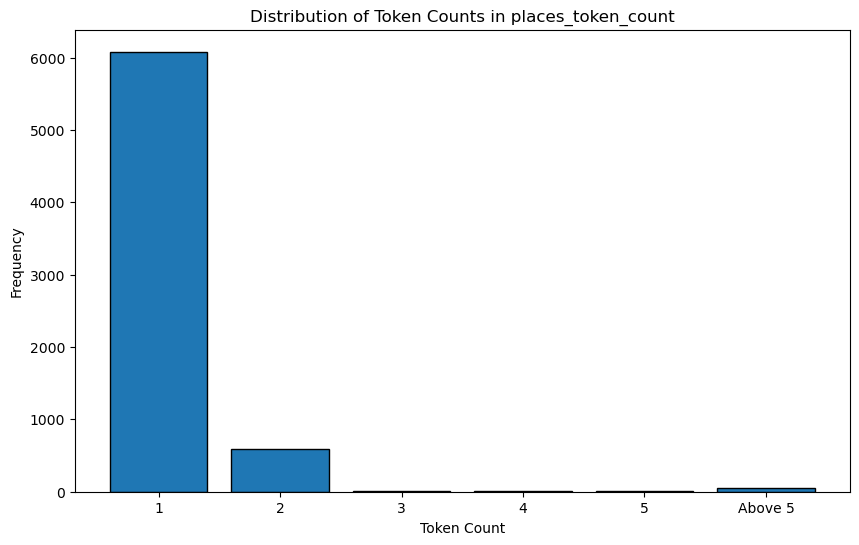

In [8]:
import matplotlib.pyplot as plt

counts_1 = len(df[df['places_token_count'] == 1])
counts_2 = len(df[df['places_token_count'] == 2])
counts_3 = len(df[df['places_token_count'] == 3])
counts_4 = len(df[df['places_token_count'] == 4])
counts_5 = len(df[df['places_token_count'] == 5])
counts_above_5 = len(df[df['places_token_count'] > 5])
categories = ['1', '2', '3', '4', '5', 'Above 5']
counts = [counts_1, counts_2, counts_3, counts_4, counts_5, counts_above_5]

plt.figure(figsize=(10, 6))
plt.bar(categories, counts, edgecolor='black')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Distribution of Token Counts in places_token_count')
plt.show()

In [166]:
df.drop(columns =['places_token_count'],inplace = True)

In [173]:
df.to_csv('dataframe_clustering.csv', index =False)

## Extracting Latitude and Longitude Co-Ordinates

In [19]:
import requests
import pandas as pd
import time
from tqdm import tqdm

# Function to get latitude and longitude for a place
def get_lat_long(place):
    if len(place) > 30:
        print(f"Skipping place '{place}' as length is more than 30 characters.")
        return None, None
    
    url = f"https://geocode.maps.co/search?q={place.replace(' ', '+')}&api_key=660742ac8b0c9483916236igpc9edea"
    response = requests.get(url)
    if response.status_code == 200:
        try:
            data = response.json()
            if data:
                return data[0]['lat'], data[0]['lon']
        except ValueError as e:
            print(f"Error parsing JSON: {e}")
    else:
        print(f"Error: {response.status_code}, {response.text}")
    return None, None


# Apply function to DataFrame with delay
df['latitude'] = None
df['longitude'] = None
for index, row in tqdm(df.iterrows(), total=len(df)):
    if len(row['place']) <= 30:
        latitude, longitude = get_lat_long(row['place'])
        df.at[index, 'latitude'] = latitude
        df.at[index, 'longitude'] = longitude
    else:
        print(f"Skipping place '{row['place']}' as length is more than 30 characters.")
    time.sleep(1)  # Delay of 1 second

# Display the DataFrame with latitude and longitude
print(df)

  1%|          | 58/6750 [01:21<2:39:54,  1.43s/it]

Skipping place 'In A Tragic Incident , A 37-Year-Old Man Named Deepak Sharma From Gurugram Lost His Life In A Car Accident , Succumbing To Internal Bleeding 24 Hours After The Incident. Sharma, Who Had Sustained Injuries In The Collision, Refrained From Seeking Medical Treatment Due To His Concern For His Parents, Both Suffering From Chronic Heart Diseases. The Fear Of Causing Shock To His Parents Led Sharma To Keep The Accident A Secret, Resulting In A Delayed Response To His Critical Condition. The Incident Unfolded When Sharma'S Hyundai Verna Was Hit By A Tractor-Trolley Beneath The Dwarka Expressway Flyover Around 9' as length is more than 30 characters.


  4%|▍         | 271/6750 [06:17<2:36:38,  1.45s/it]

Skipping place 'At Least 12 Persons Were Killed And Many Others Were Injured In Accidents As Fog Played Havoc With Road Traffic Across Several States. Tragedy Struck A Telangana Family Twice Within A Few Hours, As Two Separate Accidents On Sunday Night, Which Police Blamed On Dense Fog, Left Four Relatives Among Six Persons Dead At Miryalaguda In Nalgonda District. Three Family Members Died When Their Mini Van Collided Head-On With A Lorry While They Were On Their Way To The Mortuary To Claim The Body Of A Relative, Who Had Died In A Bike Accident On The Same Stretch Just Hours Before. Three Others From The Family Were Injured In The Accident, With The Condition Is One Of Them Stated To Be Serious. A Pedestrian Was Also Killed In The Bike Accident, While The Second Accident Also Claimed The Van Driver'S Life. In Rajasthan , Three Tourists From Gujarat Died When Their Car Collided Head-On With A Vehicle In Barmer District On Monday. In Up, Two Persons Were Killed And Over A Dozen Injure

  5%|▍         | 328/6750 [07:36<2:32:49,  1.43s/it]

Skipping place 'Four Youths Were Killed When The Car They Were Travelling In Fell Into A Gorge Filled With Slush And Bushes Near Sri Anjaneyaswamy Temple, On The Outskirts Of Chikkaballapur Town, Around 60Km From Bengaluru, Saturday Night. The Deceased Are Tagore, 21, And Aryan , 18, Residents Of Chintamani And Studying In Bengaluru, And Pavan , 19, And Vasanth, 19, From Chikkaballapur. According To Manjula, Traffic Psi Chikkaballapur, The Accident Took Place A Stone'S Throw Away From The Temple. On Hearing A Huge Sound, Some Villagers Near The Temple Saw The Polo Car Sinking In The Gorge. They Alerted Traffic Police, Who Rushed To The Spot And Tried To Lift The Car. Explore Your Financial Landscape With Personalized Credit Insights.' as length is more than 30 characters.


  5%|▌         | 361/6750 [08:22<2:28:14,  1.39s/it]

Skipping place 'Four People Lost Their Lives In Two Separate Accidents In Odisha On Tuesday. While Three Members Of A Family From Chhattisgarh , Who Were On A Vacation , Were Killed When Their Car Veered Off The Jodimadeli Ghat Road In Koraput, A 35-Year-Old Police Constable Was Run Over By A Speeding Coal-Laden Truck Truck While Eating At A Roadside Eatery Near Karamdih In Sundargarh District. Explore Your Financial Landscape With Personalized Credit Insights.' as length is more than 30 characters.


  6%|▌         | 407/6750 [09:26<2:29:27,  1.41s/it]

Skipping place 'In A Shocking Incident, A Speeding Car Driver Was Recorded Hitting A Parked Motorcycle, And Later, Dragging The Bike For Over 3 Km In Gurugram , Haryana On February 1, 2023. The Video Showing The Motorcycle Being Dragged By The Car Is Going Viral On Social Media. As Per Gurugram Police , The Honda Amaze Driver Ignored Attempts By Other Commuters To Stop His Vehicle. The Perpetrator Has Been Arrested But The Cause Behind The Bizarre Incident Isn'T Clear Yet. Fortunately, No One Was Reported To Be Hurt Because Of The Incident. The Motorcycle Owner, A Bouncer By Profession, Said The Incident Occurred Around 11' as length is more than 30 characters.


  7%|▋         | 492/6750 [11:23<2:19:45,  1.34s/it]

Skipping place 'In Yet Another Terrifying Drag-And-Run Incident, A 22-Wheel Container Truck Hit A Car In Meerut, Uttar Pradesh And Then Dragged It For About 3 Kilometres As Bystanders Looked On In Shock. Visuals Of The Chevrolet Beat Hatchback Being Pushed By The Truck At A Relatively High Speed, Are Now Viral On Social Media. Fortunately, All Four Occupants Of The Car Managed To Escape Without Any Serious Injuries, After Jumping Out Of The Car In Time. Watch The Video Of The Incident Captured By An Onlooker Below - As Per The Account Of Local Witnesses, The Car Was Dragged By The Intoxicated Truck Driver Following An Altercation Between Him And The Car Occupants. The Drunk Truck Driver Then Allegedly Try To Flee The Scene, However, He Was Apprehended By Cops Soon After. The Hit-And-Drag Incident Comes Only A Day After A Speeding Truck Hit A Horse-Driven Cart Used In Weddings Carrying Five People In Meerut. Three People, Including Two Brothers, Were Killed In The Incident And The Remai

  8%|▊         | 536/6750 [12:23<2:20:21,  1.36s/it]

Skipping place 'A 48-Year-Old Woman, Prema , Has Died After A Car, Being Driven By Nagbhushana, Rammed Into Her And Her Husband, Krishna (58) Near Konanakunte Cross On Saturday Night. According To The Fir (First Information Report) Filed At The Kumaraswamy Layout Traffic Police Station , The Accident Occurred Around 9.45Pm On Saturday Night When Nagabhushana, After Wrapping Up A Shoot, Was Driving Towards His Jp Nagar Residence From Uttarahalli . According To Police, Nagabhushana Knocked Down The Couple On Vasanthapura Main Road On Saturday Night And Then Hit An Electricity Pole. The Actor Then Shifted The Couple To A Hospital, But The Woman Succumbed To Injuries On The Way While Her Husband Is Undergoing Treatment In The An Icu. The Couple Were Injured In Head, Neck And Back. The Couple’S Son Has Also Filed A Police Complaint. The Car Has Been Seized And The Actor Is Out On Station Bail . Further Probe Is On.' as length is more than 30 characters.


  9%|▉         | 591/6750 [13:40<2:18:51,  1.35s/it]

Skipping place 'In Yet Another Bone-Chilling Hit-And-Drag Incident, A Traffic Police Constable Was Dragged Onto The Bonnet Of A Car For About 2 Kilometers Before It Came To A Halt Following An Accident In Ghaziabad , Uttar Pradesh On Friday. The Incident Took Place Near Shipra Mall In Indirapuram , And The Two Men That Were Riding In The Car At The Time Have Now Been Arrested, While Police Are On The Lookout For The Third Accused Who Was Present In The Car. Ankit Kumar, A Head Constable With Ghaziabad Police , Said In His Complaint That He And Three Other Cops Were Carrying Out A Routine Check Near The Mall At Around 4' as length is more than 30 characters.


 10%|▉         | 661/6750 [15:18<2:26:20,  1.44s/it]

Skipping place 'Popular Singer Kumar Bishwajit Dey’S Son Nibir Kumar Is In Critical Condition After Suffering Severe Injuries In A Car Crush In Toronto, Canada . He’S Currently Under Observation In Icu And Remains Critical With Severe Burn Injuries. Kumar Bishwajit And His Wife Naima Sultana Have Already Reached To Be With Their Son. A Surgery Will Be Done To Remove The Blood Clots Only After Nibir’S Condition Improves. Nibir Kumar, The Only Son Bangladeshi Singer Kumar Bishwajit, Lives In Canada For Higher Studies. According To Reports, Three Bangladeshi Students Were Also Killed In The Same Road Accident . The Deceased Were Identified As Shahriar Khan, Angela Barai And Aryan Dipta. All Four Of Them, Students Of Humber College, Were Heading For A Common Friend’S Place When Their Car Lost Control On Highway 427 Southbound Ramp To Dundas Street West. As Per Canadian Police Source, Nibir Himself Was Driving The Car And Police Suspect It’S A Case Of Rash Driving. The Bangladeshi Singer’S 

 11%|█         | 720/6750 [16:40<2:17:23,  1.37s/it]

Skipping place 'A Family Of Five, Including An Eight-Month-Old Boy And Two Women, Suffered Injuries After Their Car Was Trapped Between A Truck And An Oil Tanker In A Crash On Pune-Solapur Highway On Saturday. Sub-Inspector Hanumant Tarte Said,“The Family, Including Brothers Subodh Prashant Patil And Sarang, Was Heading To Loni Kalbhor By Car From Badlapur. Subodh, Who Was Driving, Slowed Down After A Truck Ahead Stopped Due To Some Vehicles Taking A U-Turn From A Gap In The Road Divider At The Spot. The Oil Tanker Crashed Into The Car From Behind. Due To The Impact, The Car Collided With The Truck In Front Of It And Was Trapped Between The Two.” Explore Your Financial Landscape With Personalized Credit Insights.' as length is more than 30 characters.


 22%|██▏       | 1514/6750 [35:03<1:58:27,  1.36s/it]

Skipping place 'In A Tragic Incident, Four People Were Instantly Killed After The Bmw Car They Were Travelling In Collided With A Container Truck On The Purvanchal Expressway In The State Of Uttar Pradesh On Friday. The Four Were Travelling From Rohtas District In Bihar, And Heading Towards Delhi When The Crash Took Place. The Accident Took Place On Milestone 83 Near Haliapur Police Station. The Container Truck Was Going From Lucknow To Bihar, According To Local Police. "A Loud Noise Was Heard When The Bmw Collided And The Impact Was Such That All Four Passengers In The Car Were Cut Into Pieces", Said A Local Who Had Also Informed Up Police About The Incident. Shockingly, An Occupant Sitting In The Car Went Live On Facebook Minutes Before The Crash, Recording A Video Of The Overspeeding Bmw. The Luxury Car Can Be Seen Touching Speeds Of Over 200 Km/H Multiple Times In The Video, And Even Going Up To 230 Km/H. The Viral Video Also Shows One Of The Passengers Saying "All Four Will Die". 

 25%|██▍       | 1668/6750 [38:37<2:00:38,  1.42s/it]

Skipping place 'Two Persons Suffered Injuries After A Speeding Car Travelling In The Wrong Direction Rammed Into A Car At Gowlidoddi In Gachibowli. Though The Accident Occurred On May 21, It Came To Light On Sunday After Cyberabad Traffic Police Shared The Cctv Footage Of The Incident. “The Accused Driver And The Victim Driving The Second Car Suffered Injuries. Both Are Out Of Danger. A Case Has Been Registered Against The Accused,” Cyberabad Traffic Police Said. Explore Your Financial Landscape With Personalized Credit Insights.' as length is more than 30 characters.


 35%|███▌      | 2395/6750 [55:32<1:39:42,  1.37s/it]

Skipping place 'Bhojpuri Singer-Actor Sunil Chaila Bihari Met With A Car Accident And Is Undergoing Treatment At A Hospital In Delhi. The Actor Has A Neck Injury And It Is Being Reported That Three More People - Singer Neeraj Pali, Contractor Subodh Mahato And The Driver Were In The Car Along With Sunil Chaila Bihari. According To The Report, The Accident Took Place Near Mathura At The Yamuna Expressway On Wednesday. The Car Was Heading Towards New Delhi. After Several Injuries, Everyone Was Admitted In A Private Hospital In Mathura And Later They Were Referred To Delhi On Thursday. Reportedly, A Dumper Crushed Two People On Yamuna Expressway Who Died On The Way To The Hospital. It Is Said That The Diesel Of The Canter Ran Out Near The Village Of Sarol. The Driver Made The Canter Stand On The Road And Went To Pick Up Diesel. Later, A Sand-Filled Dumper Coming From Agra At A Fast Speed Overturned Uncontrollably Taunting Two People Who Were Sleeping On The Roadside. The Driver Of The Dum

 36%|███▋      | 2452/6750 [56:51<1:42:16,  1.43s/it]

Skipping place 'A Man Was Killed And Two Others Injured After Their Car Hit A Truck On The Pune E-Way Around 9Pm On Saturday, After The Unidentified Truck Driver Braked Suddenly. An Fir Was Filed Against Him. Lalbaug Resident Amey Patil (28) Died, Kanjurmarg Resident Shweta Anerao (25) And Mulund Resident Prathamesh Manchekar (28) Are Being Treated At A Panvel Hospital. Explore Your Financial Landscape With Personalized Credit Insights.' as length is more than 30 characters.


 37%|███▋      | 2467/6750 [57:11<1:39:25,  1.39s/it]

Skipping place 'A 32-Year-Old Pillion Rider Of A Bike Was Killed And Four Others Injured After A Bmtc Bus Hit A Car And Two Two-Wheelers On Thanisandra Main Road, North Bengaluru, Late Friday Evening. The Accident Took Place At Around 7.45Pm Near Sampigehalli Police Station. The Bus Driver Told Police That Brake Failure Was The Main Reason For The Accident. Police Identified The Deceased As Ayub. He Was Rushed To A Nearby Hospital Where He Died Around 10.35Pm, Police Said. Explore Your Financial Landscape With Personalized Credit Insights.' as length is more than 30 characters.


 42%|████▏     | 2827/6750 [1:05:34<1:32:49,  1.42s/it]

Skipping place 'A Person Died And Another Suffered Minor Injuries When A Car In Which They Were Travelling Collided With A Roadside Culvert Near Sri Chaudeshwari Temple At Shirady Village Under Uppinangady Police Station Limits On Thursday. Police Identified The Victim As Nagaraj Rao K N, 61, A Resident Of Jalahalli Cross In Bengaluru. Hanumanth Naik, 28, A Resident Of Ananthpur District In Andhra Pradesh, Sustained Minor Injuries In The Accident. Police Said Rao And Naik, Who Were Travelling In A Maruti Swift Car, Were On Their Way To Puttur From Bengaluru, When The Accident Took Place. Rao, Who Was Driving The Car, Veered To The Extreme Right Side Of The Road, Resulting In The Car Crashing Into The Culvert. A Case Has Been Registered At The Uppinangady Police Station Based On A Complaint Filed By Naik. Explore Your Financial Landscape With Personalized Credit Insights.' as length is more than 30 characters.


 43%|████▎     | 2897/6750 [1:07:11<1:30:13,  1.41s/it]

Skipping place 'A Car Plunged Into The Left Main Canal Of Vamsadhara River In Srikakulam District On The Early Hours Of Friday. Two Of The Five People Travelling In The Car Have Died. The Deceased Have Been Identified As Pavan And B Chandramohan. Both Of Them Are Employees Of Visakhapatnam-Based Coromandel Fertilizers, According To The Local Police. Pavan Was A Resident Of Rajahmundry While Chandramohan Hailed From Khammam. The Three Others In The Car— M Maheshwara Rao, S Durga Naga Praveen And Venkatagiri Prasad Sustained Minor Injuries. Hiranmandalam Police Said That A Group Of Ten People Had Gone To Centurion University In Parlakhamundi In Odisha To Attend A Meeting. The Group Was Travelling In Two Cars, With Five People In Each Car. While On Their Way Back, The Car Plunged Into The Canal In The Dark. While The Three People Who Survived Managed To Swim To Land, Two— Those Who Died Got Stuck In The Car And Eventually Drowned. Hiramandalam Police Led By Sub-Inspector K Govinda Rao Rea

 45%|████▍     | 3028/6750 [1:10:14<1:27:18,  1.41s/it]

Skipping place 'Telugu Hero Sampoornesh Babu Who Is Fondly Known As Burning Star Among His Fans Has Escaped A Deadly Car Accident Which Took Place Earlier Today At The Siddipet Town In Telangana. The Actor Was On His Way To Hyderabad Along With Wife And Daughter In An Suv. The Incident Took Place Today (November 27) Around 11.30 Am Near The New Bus Station In Siddipet. According To Reports, An Rtc Bus Has Rammed Into Sampoornesh Babu’S Car And Luckily, The Family Escaped With Minor Injuries. Soon After The Collision, Locals Rushed To The Spot And Helped The Kobbari Matta Actor And His Family. After Informing The Police About The Accident, They Sent Sampu To A Nearby Hospital To Get The Required Treatment For The Minor Injuries. Onlookers Claim That It Was The Bus Driver’S Rash Driving That Led To The Accident. The Police Arrived At The Venue, Enquired About Sampoornesh & His Family, And Reportedly Arrested The Driver. It’S Said That The Car Was Partially Damaged. On Tuesday (November 2

 46%|████▌     | 3112/6750 [1:12:10<1:23:42,  1.38s/it]

Skipping place 'A Mother-Daughter Duo, Waiting For An Auto-Rickshaw Under The Sector 37 Flyover In Noida, Run Over By A Car On September 20. The Car Also Hits The Woman’S Husband. Status' as length is more than 30 characters.


 47%|████▋     | 3187/6750 [1:13:55<1:23:34,  1.41s/it]

Skipping place 'Marathi Cinema 'S Popular Playback Singer , Anand Shinde Met With A Major Car Accident On Pune - Solapur Highway. The Accident Took Place Around 2.30 Am At The Varkute Village Near Indapur. As Per A Report, Anand Was Headed To Sangola Town From Mumbai With Four Others. Shinde Has Suffered Some Injuries On His Leg But His Condition Is Said To Be Stable. However, The Condition Of His Driver Is Said To Be Serious. According To The Report, The Singer Has Suffered Some Injuries On His Leg. However, His Condition Is Said To Be Stable. But, The Car'S Driver Is Said To Be In Serious Condition. He Has Been Admitted To The Hospital. Anand, On The Other Hand, Has Left For Pune. The Incident Took Place When Anand Was Heading To His Village Because His Son Utkarsh Is Planning To Contest The Election. Shinde'S Driver Has Been Admitted To The Hospital, While The Singer Has Left For Pune.' as length is more than 30 characters.


 48%|████▊     | 3219/6750 [1:14:39<1:20:52,  1.37s/it]

Skipping place 'Hyderabad, Three People, Including Two Female Junior Artists, Were Killed And Another Person Was Injured When The Car In Which They Were Travelling Hit A Tree On Saturday In Hyderabad. The Accident Occurred At Around 3.30 A.M. Near Hyderabad Central University Under The Limits Of The Gachibowli Police Station Of Cyberabad Police Commissionerate. The Car, Which Was On Its Way From Gachibowli To Lingampally And Was Being Driven At A High Speed, Hit The Roadside Tree. Such Was The Impact Of The Collision That The Vehicle Broke Into Pieces. Abdul Raheem , A 25-Year-Old Bank Employee Who Was Driving The Car, Was Also Killed In The Accident. The Junior Artists, Who Died In The Mishap Were Identified As N. Manasa (23) And M. Manasa (21). Another Junior Artiste Sai Siddhu Was Injured And Shifted To A Nearby Hospital. Police Shifted The Bodies To Osmania General Hospital For Autopsy And Have Launched An Investigation. The Two Junior Artists Were Staying In A Hostel In The Ameerp

 48%|████▊     | 3233/6750 [1:14:58<1:22:52,  1.41s/it]

Skipping place 'A 26-Year-Old Man Had A Narrow Escape After His Car Was Hit By A Bus Of Provincial Armed Constabulary (Pac) In Nazarbagh Area Of Kaiserbagh In The Wee Hours On Friday And Crashed Into A Complex Damaging A Few Shops. Zakir Ali , A Hazratganj Resident, Was Returning From A Marriage Party When The Accident Took Place. Explore Your Financial Landscape With Personalized Credit Insights.' as length is more than 30 characters.


 48%|████▊     | 3269/6750 [1:15:48<1:19:51,  1.38s/it]

Skipping place 'Bollywood Actor Hemant Birje And His Wife Were Injured After Their Car Met With An Accident On The Mumbai-Pune Expressway On Tuesday Night, Police Said. The Car Ran Into The Road Divider Near Urse Toll Plaza Around 8 Pm, Said An Official. The Actor And His Wife Suffered Minor Injuries While Their Daughter Remained Unhurt, Said Inspector Satyawan Mane Of Shirgaon Police Outpost. "Birje And His Wife Are Being Treated At Nearby Pawana Hospital," He Said.' as length is more than 30 characters.


 49%|████▉     | 3340/6750 [1:17:27<1:19:37,  1.40s/it]

Skipping place 'This Old And Rusty Car Has Been Abandoned In Front Of The Police Station In Lajpat Nagar, Where The Central Market Is. Such Cars Should Be Towed Immediately. Explore Your Financial Landscape With Personalized Credit Insights.' as length is more than 30 characters.


 50%|████▉     | 3352/6750 [1:17:43<1:20:04,  1.41s/it]

Skipping place 'Car Falls From Bandra Bridge Explore Your Financial Landscape With Personalized Credit Insights.' as length is more than 30 characters.


 52%|█████▏    | 3532/6750 [1:21:54<1:13:10,  1.36s/it]

Skipping place 'A 24-Year-Old Woman Died While Two Of Her Friends Were Injured When A Dumper Truck Crashed Into Their Car In Gurgaon’S Ambedkar Chowk In Sector 52 On The Intervening Night Of Saturday And Sunday, The Police Said. After The Accident, The Dumper Driver Fled The Spot. The Three Women Were Returning To Their Apartment In Sushant Lok When A Truck Rammed Their Vehicle. Tnn Explore Your Financial Landscape With Personalized Credit Insights.' as length is more than 30 characters.


 52%|█████▏    | 3537/6750 [1:22:00<1:07:50,  1.27s/it]

Skipping place 'Late Night On Febuary 15 Deep Sidhu Met With An Accident And Couldn’T Survive The Fatal Injuries. After His Demise, His Brother Surjeet Filed An Fir Against The Truck Driver, With Whose Vehicle Deep’S Car Collided. The Complaint Was Lodged Under Ipc Sections 279 (Rash Driving) And 304 A (Causing Death By Negligence). Now Reports Have Come That The Driver Who Was At Large, Has Been Arrested By The Police From The Delhi Bypass. According To The Reports, The Accused Driver Has Been Identified As Qasim Khan , A Resident Of Singar Village. The Driver Reportedly Was Transporting Coal From Ahmedabad To Muzaffarnagar At The Time Of The Accident. Sho Of Kharkhoda, Jaspal Singh Said That During The Questioning, The Accused Has Admitted That His Negligence Led To The Misfortune Incident. The Accused Has Reportedly Mentioned That The Truck Was Moving And He Hit The Brake Due To Negligence, Following Which Deep’S Car Rammed Into The Vehicle’S Rear. Further, The Accused Driver Will B

 52%|█████▏    | 3543/6750 [1:22:08<1:12:04,  1.35s/it]

Skipping place 'Three Police Personnel Suffered Injuries After The Car They Were Travelling By Met With An Accident Near Khalapur On Pune-Mumbai Expressway Around 4.15Am On Saturday. The Injured Include Sub-Inspector Prashant Desai (40) And Constables Kapil Nemade (35) And Avinash Godage (25). “Desai Is Attached To The Manikpur-Vasai Police Station And Has Suffered A Skull Fracture. He Is Admittedtoapollo Hospital,Cbd-Belapur And Is Critical. The Two Constables, Nemade And Godage, Were Seated Behind And Have Sustained Minor Body Injuries,” Police Said. Godage Said, “Desai Had Told Us That We Were Going To Khalapur To Apprehend A Notorious Chain Snatcher After A Tip-Off. We Had Hired A Private Honda City Car . After We Crossed The Bhatan Tunnel, A Speeding Tempo Plying On The Third Lane Suddenly Switched Over To First Lane. When Our Driver Applied The Brakes And Moved Towards The Median, The Tempo’S Rear Endhitour Car’Sleft Side, Resulting In The Accident.” Explore Your Financial Landsc

 57%|█████▋    | 3879/6750 [1:29:55<1:05:17,  1.36s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)


 58%|█████▊    | 3888/6750 [1:30:07<1:05:42,  1.38s/it]

Skipping place 'In An Accident Involving Five Vehicles On The Curchorem-Quepem Highway, The Driver Of A Car Hit Two Four-Wheelers And Two Bikes On Thursday Evening, Fatally Injuring One. Junaid Korawale, 25, Who Was Riding One Of The Bikes, Died On The Spot. The Impact Threw Him Off His Two-Wheeler And Into A Gutter. He Sustained Fatal Head Injuries. The Accident Occurred At Tanki In Xeldem. Police Said That Korwale Was Headed To Tilamol In Quepem When The Car Moving In The Same Direction Crashed Into Him. The Car First Hit A Parked Vehicle Loaded With Marble Slabs Before Colliding With An Oncoming Four-Wheeler And Two Bikes, Police Said. The Rider Of The Other Two-Wheeler Was Rushed To South Goa’S Premier Hospital, Hospicio, In Margao. Quepem Police Inspector (Pi) Brutano Pexeioto Said That The Driver Of The Car Has Been Arrested For Rash And Negligent Driving. Police Sources Said Korawale’S Body Has Been Taken To Hospicio For Postmortem. Tanki Resident Christanand Pednekar Blamed The

 60%|██████    | 4050/6750 [1:33:47<1:00:51,  1.35s/it]

Skipping place 'A Woman From Kalyan Died, While Her Husband Suffered Injuries, After Their Car Rammed Into A Trailer Near Kamshet Tunnel On The Mumbai-Pune Expressway Around 3.30Pm On Friday. Pune Rural Police Identified The Deceased As Sunita Shingekar. Her Husband, Hemant, Is Undergoing Treatment At A Hospital In Nigdi. A Kamshet Police Officer Said They Were On Their Way To Pune. “After Reaching Kamshet Tunnel, Hemant Lost Control Of The Vehicle And Rammed Into A Trailer From Behind. The Impact Of The Accident Was Such That Sunita Was Critically Injured. Hemant Escaped With Minor Injuries,” He Said. Passersby Took The Couple To Lokmanya Hospital In Nigdi, Where Sunita Succumbed To Multiple Injuries While Undergoing Treatment, The Officer Said. The Incident Did Not Affect Traffic On The Stretch. Police Said They Were Registering A Complaint. Explore Your Financial Landscape With Personalized Credit Insights.' as length is more than 30 characters.


 60%|██████    | 4074/6750 [1:34:19<59:58,  1.34s/it]  

Skipping place 'At Least Six People, Including A Minor Girl, Were Killed In Three Separate Road Accidents In Patna, Bhagalpur And Supaul Districts On Sunday. While Three People Were Killed And Four Injured When An Autorickshaw Was Hit By A Speeding Bus Near Beldari Chak On Patna-Gaya Road Under Gaurichak Police Station In Patna District, Two Youths Riding A Motorbike Was Run Over By A Speeding Truck In Supaul District. In Bhagalpur, A Four-Year-Old Girl, Sonakshi, Was Crushed To Death By A Speeding Car. Gun Factory Unearthed' as length is more than 30 characters.


 60%|██████    | 4082/6750 [1:34:29<59:07,  1.33s/it]

Skipping place 'Mumbai A Woman Was Killed And Six Men Were Injured When A Driver Lost Control Of His Dumper And Rammed It Into Three Cars On The Mumbai-Ahmedabad National Highway In Vasai On Monday Evening. The Police Said The Dumper Driver Was Speeding And Trying To Overtake On The Two-Lane Sativali Bridge In Vasai When The Incident Took Place Around 7Pm. The Dumper, Which Was Headed To Gujarat, Landed On The Mumbai Side Of The Bridge. It Then Collided With Three Vehicles Heading Towards Mumbai Before Turning Turtle And Falling Off The Bridge. A Woman Who Was Seated In The Front Seat Of A Car Which Was Hit By The Dumper Died On The Spot. Six Others, Including The Dumper Driver, Sustained Serious Injuries. The Police Said That The Identities Of The Victims, Including The Deceased, Has Not Been Established Yet. A Case Of Negligent Driving Will Be Filed Against The Dumper Driver, Whose Condition Is Critical, Added The Police. Following The Accident, Evening Peak-Hour Traffic On The Highw

 61%|██████    | 4106/6750 [1:35:01<58:31,  1.33s/it]  

Skipping place 'Four People From The City On Their Way For A Wedding To Pune Died While Four Others Suffered Serious Injuries After The Car They Were Travelling In Collided Against The Railings On The Mumbai-Pune Expressway At Kamshet Around 3 Pm On Wednesday. The Driver Lost Control Over The Wheel After A Front Tyre Of The Car Burst And The Vehicle Smashed Against The Cement Railings. The Deceased-Nikhil Prakash Rao, Siddesh Anil Bede, Nitin Rushipal Jinwal And Rupesh Jadhav-Were Residents Of Kurla And Sewri. They Were On Their Way To Pune To Attend The Wedding Of A Close Friend On Wednesday Evening. The Police Said That The Deceased And The Injured Were Aged Between 20 And 27. Of The Four Deceased, Two Died On The Spot. The Injured Were Rushed To A Private Hospital On The Old Pune Highway Where Two Others Died While Undergoing Treatment. The Injured Were Identified As Akshay Chavan, Vaibhavi Sudrik, Jayashree Rathod And Neeta Chevilkar. The Eight Persons Had Boarded The Car At Kurla 

 62%|██████▏   | 4160/6750 [1:36:14<57:57,  1.34s/it]  

Skipping place 'Three Persons Were Killed In A Road Accident On Thursday Afternoon When Their Car Hit A Truck Parked In The Middle Of A Road, After It Broke Down, At Kokangaon Phata On Mumbai-Agra Highway. Constable Pandit Chaure, Attached To Dongri Police Station In Thane, Was With His Wife And Two Children, And His Friend, Sanjay Bagul. They Were Heading To Satana When The Accident Occurred. Bagul Got Confused As The Truck Was Parked And He Lost Control Of The Vehicle. A Bus Coming From Behind Hit The Car, And Dragged It At Least 100 Feet Ahead. Chuare’S 18-Year-Old Daughter Mayuri Died On The Spot, While Vaishali (39) Died Late On Thursday. His Son Sagar (22) Died Early On Friday At A Private Hospital. Head Constable Eknath Pawar Of Pimpalgaon Police Station Said The Truck Was Parked On The Highway Without Precautions. Chaure And Bagul Are Undergoing Treatment At A Private Hospital. Tnn Explore Your Financial Landscape With Personalized Credit Insights.' as length is more than 30 ch

 63%|██████▎   | 4267/6750 [1:38:37<54:37,  1.32s/it]

Skipping place '(This Story Originally Appeared In On Nov 21, 2017) Kolara' as length is more than 30 characters.


 66%|██████▌   | 4436/6750 [1:42:25<52:12,  1.35s/it]

Skipping place 'A 41-Year-Old Assistant Commandant Of Crpf Was Killed After His Car Rammed A Truck Near Baraut Highway Under The Limits Of Handia Police Station On Thursday Morning. His Driver Was Also Injured In The Accident. The Deceased Santosh Kumar Was A Resident Of Chhapra In Bihar. According To Handia Police, The Accident Occurred When Kumar Was Returning To Delhi From His Home Town. After Being Alerted, Police Sent The Injured Driver To Hospital. The Driver Vinod Kumar Is A Resident Of Devri In Haryana. Police Said The Deceased Was Posted At 122 Battalion In Delhi. The Body Has Been Sent For Postmortem Examination. Explore Your Financial Landscape With Personalized Credit Insights.' as length is more than 30 characters.


 66%|██████▌   | 4464/6750 [1:43:03<51:27,  1.35s/it]

Skipping place 'Popular Tollywood Producer Suresh Babu Has Reportedly Rammed His Car (Ts09Ex2668) Into A Two-Wheeler Near Imperial Garden (Secunderabad) On Sunday Night. He Is Said To Be Driving The Vehicle At The Time Of Collision And An Accident Case Has Been Filed Against Him At The Kharkhana Police Station . Three People, Including A Minor, Have Sustained Severe Injuries And Are Currently Undergoing Treatment In The Hospital . As Per Police Revelation, The Accident Happened Around 10' as length is more than 30 characters.


 67%|██████▋   | 4499/6750 [1:43:49<48:24,  1.29s/it]

Skipping place 'A Malad Resident Was Among The Three People Who Died In A Luxury Bus-Trailer Collision At Indapur Near Panvel On The Mumbai-Goa Highway Early On Monday. A Car Too Was Damaged In The Accident . Four Members Of A Prabhadevi Family That Was Travelling In The Car Were Among The 15 Injured In The Mishap. Police Officials Said Around 2.30Am, The Luxury Bus Of Chirag Travels, Which Was Plying Towards Mumbai, Tried To Overtake The Car, And Rammed Into The Trailer That Was Heading Towards Goa. As The Car Driver Did Not Hit The Brakes On Time And Collided Into The Bus. Ramkishan Jaybhaye (38), The Trailer Driver, And Balkrishna Dapale (45), A Bus Passenger From Malad, Died On The Spot. The Bus Driver, Rajkumar Yadav (45), Died En Route To Hospital. “Dapale Was An Ac Operator With Iocl At Bandra. The Accident Was Caused Due To The Bus Driver’S Reckless Driving,” Claimed Assistant Inspector Anil Meshram Of Mangaon Police Station. Mangaon Police Registered A Case Against The Decease

 68%|██████▊   | 4601/6750 [1:46:08<47:23,  1.32s/it]  

Skipping place 'Five Persons Travelling In A Car Died After The Vehicle Collided With A Speeding Truck In Front Of The Police Training School (Pts) In Khandala On The Old Mumbai-Pune Highway On Saturday Night. Four Of The Deceased Are Women. Two Other Occupants Of The Car Were Seriously Injured. The Lonavla Police Said That The Accident Occurred Around 9Pm. The Accidenthit Car Was Registered With The Thane Rto. According To The Police, Of The Seven Persons Travelling In The Car, Six Were Women. Four Women And The Driver Were Killed On The Spot. The Two Injured Women Have Been Admitted To A Private Hospital In Lonavla And Their Condition Is Critical. Inspector Chandrakant Jadhav Of The Lonavla City Police Said That The Identity Of The Deceased Could Not Be Established Till Late In The Night As Their Heads And Faces Were Smashed Beyond Recognition. Jadhav Said That A New Resort Had Opened In Lonavla And All The Vehicle Occupants Were Employed There. The Hotel’S Official Drop Facility Was

 68%|██████▊   | 4607/6750 [1:46:16<47:49,  1.34s/it]

Skipping place 'Nainital/ Mussoorie / Uttarkashi' as length is more than 30 characters.


 71%|███████   | 4776/6750 [1:50:05<42:07,  1.28s/it]

Skipping place 'A Speeding Car Mowed Down Four People On The Chennai-Bengaluru Highway At Kandhikuppam In Krishnagiri District On Sunday. The Accident Triggered Mob Violence, With The Public Setting Fire To The Car That Caused The Deaths And Pelting Passing Vehicles With Stones.They Also Smashed The Glass Panes Of A Fire Engine That Came To The Spot. Police Used Mild Lathi Charge To Disperse The Protesters Who Sat On The Highway Blocking Traffic. Witnesses Said Two Speeding Cars That Were Trying To Overtake Each Other Led To The Accident. The Driver Of The Car That Ran Over The People Was Also Injured And Was Admitted To Hospital. The Deceased Were Identified As Bharath Samundi, 17, His Relative S Gokul, 17, Both From Kandhikuppam, Vana Ja, 45, From Mallapadi And Dharman, 40, From Marudha Palli. Six Others Who Were In Jured Have Been Admitted To Hospitals. Explore Your Financial Landscape With Personalized Credit Insights.' as length is more than 30 characters.


 72%|███████▏  | 4830/6750 [1:51:18<43:09,  1.35s/it]

Skipping place 'A Woman Died And Seven Others Suffered Injuries After A Car Rammed Into Another Car On The Pune Expressway At Malavli, On Saturday Around 8.45Am. Lonavla (Rural) Police Said Both The Vehicles Were Headed Towards Pune. The Deceased Woman Was Identified As Janabai Ananta Sanas (37), A Resident Of Koparkhairane. She Succumbed To Her Injuries In The Hospital. The Driver Of The Car That Was Rammed Into, Suyesh Shantaram Bhikule (27) Of Mankhurd, Lodged A Complaint With The Police. Bhikule Was Driving In Second Lane Of The Corridor, When The Other Car Hit His Vehicle. Police Said They Would File A Case Of Rash And Negligent Driving Once They Identify The Driver Of The Second Car. Explore Your Financial Landscape With Personalized Credit Insights.' as length is more than 30 characters.


 72%|███████▏  | 4838/6750 [1:51:29<43:46,  1.37s/it]

Skipping place 'At Least Eight People, Including A Lawyer And A College Student, Died In Separate Accidents On The City’S Outskirts And In Kancheepuram On Tuesday Night And In The Early Hours Of Wednesday When The New Year Revelry Was At Its Peak. Police, However, Said They Were Not Able To Confirm If Any Of The Accidents Were Directly Related To The Celebrations. While Hotels And Clubs Were Packed And There Were Thousands Of People On The Roads Through The Night, The Biggest Party Spots, Like Always, Were The Marina And The Elliot’S Beach In Besant Nagar. About 15,000 Police Personnel Were Deployed Across The City And About 75 Flyovers Were Blocked For Vehicles From 10Pm On Tuesday. There Were Few Untoward Incidents. S Thangavelu, A 20-Yearold Third Year Bcom Student Of A Private College And Resident Of New Perungalathur , Died After He Rode His Two-Wheeler Into A Bus Parked By The Side Of A Road Near Tambaram. His Two Friends, Who Were Riding Pillion, Escaped With Injuries. Police Sa

 76%|███████▋  | 5160/6750 [1:58:45<35:34,  1.34s/it]

Skipping place 'The Pedestrian Who Was Injured In A Road Accident Involving Bollywood Actor Rajat Bedi 'S Car In Suburban Andheri Died During Treatment, Police Said On Wednesday. Following The Death Of The Injured Victim On Tuesday Late Night, D N Nagar Police Have Added Section 304-A (Causing Death By Negligence) Of The Indian Penal Code In The Fir Registered Against The Actor, An Official Said. The Actor Is Not Yet Arrested, He Said. "The Accident Victim Rajesh Baudh , A Labourer, Was Declared Dead In The Cooper Hospital Where He Was Being Treated For The Last Two Days," The Official Said. The Incident Occurred On Monday Evening Near A Temple In Andheri When The Actor Was On His Way Home, According To Police. The Pedestrian, Who Was In An Inebriated Condition, Suddenly Came Into The Middle Of The Road And Got Hit By The Actor'S Car Before The Latter Could Apply Brakes. The Actor Took The Injured Person To The Nearby Cooper Hospital And Then Went To D N Nagar Police Station Where He I

 80%|████████  | 5424/6750 [2:04:46<29:04,  1.32s/it]

Skipping place 'Bareilly/Pilibhit/Kheri/Shahjhanpur' as length is more than 30 characters.


 82%|████████▏ | 5543/6750 [2:07:27<26:37,  1.32s/it]

Skipping place 'Three Members Of A Family Died On Thursday Evening When A Car Rammed Into A Truck Near Debra Police Station Of Buramal On National Highway 6. The Accident Took Place When Four Family Members From Belur In Howrah Were Returning After Their Week Long Visit To Puri Along With The Driver. The Seven-Year Old Daughter Priya Tewari, Her Mother Sulekha Tewari And Priya’S Father Subrata Nandi Died On The Spot. Joy Tewari, Their Son, And Driver Of The Vehicle Deepu Patra Survived. They Were Rushed To Midnapore Medical College With Severe Head Injuries. The Car In Which The Family Was Travelling Rammed Into A Truck Which Was Also Heading Towards Howrah. Nandi’S Car Has Been Destroyed From The Impact Of The Accident. A Senior Officer Of Kharagpur Police Said, “We Rushed To The Spot Immediately After The Accident. We Had Sent The Injured To The Hospital For Treatment As The Survivors Were In A Critical Condition. The Other Three Are Dead. We Have Informed The Survivors Of Nandi Fami

 82%|████████▏ | 5554/6750 [2:07:42<27:04,  1.36s/it]

Skipping place 'Arpita Chakrabarty | Tnn Almora' as length is more than 30 characters.


 84%|████████▍ | 5697/6750 [2:11:01<24:58,  1.42s/it]

Skipping place 'A Woman Was Killed And Two Relatives Injured On Monday When The Car They Were Travelling In Fell Into A 200-Feet Deep Gorge Near Kodaikanal. The Deceased Was Identified As Kulasiammal, 35, Hailing From Kavichikombu, A Village Nestled In The Lower Kodaikanal Hills. The Injured Were Identified As Gandhi, 40 And Velusamy, 37. The Accident Took Place On Ghats Road When The Family Was Returning To Their Village After Dropping Off Gandhi’S Daughter At A Boarding School In Batlagundu In Dindigul District. The Injured Were Rushed To Theni Government Hospital For Treatment. The Thandikudi Police Have Registered A Case And Are Conducted Inquiries. Explore Your Financial Landscape With Personalized Credit Insights.' as length is more than 30 characters.


 87%|████████▋ | 5890/6750 [2:15:31<20:10,  1.41s/it]

Skipping place 'A Head-On Collision Between Two Cars Triggered A Pileup Involving Five More Vehicles Killing Five People On The Spot Near Narthamalai In Pudukottai District On Wednesday. The Accident That Took Place Around 5 Pm On The Trichy-Pudukottai National Highway Near Ammachatiram, Left 18 Others, Including Four Children, With Grievous Injuries. The Condition Of Two People Undergoing Treatment In Pudukottai Medical College Hospital Remains Critical. While Preliminary Investigation Reveals That A Tyre Burst In One Of The Cars Caused The Accident, Police Say That The Car Lost Control And Collided With Another Vehicle Coming In The Opposite Direction Before Halting In The Middle Of The Road. Thereafter, Police Said Five Vehicles Coming In Both Directions Rammed Into Them. The Deceased Have Been Identified As M Chidambaram, 50, S Rengarajan, 45, Karthick, 35, R Nagarathinam, 78, And K Nagalakshmi, Who Were Apparently Travelling In The First Two Cars. The Accident Was Triggered By An 

 89%|████████▉ | 6035/6750 [2:18:53<16:49,  1.41s/it]

Skipping place 'Two Persons Were Killed And Four Were Injured By Speeding Container Trailers In Two Separate Accidents Along The Kalamboli Stretch Of The Mumbai-Pune Expressway On November 24 And 26 . On November 24, Sanjay Khule (23), Ajay Barge (22) And Dagdu Jaid (36) Had Come To Navi Mumbai From Pune For Some Personal Work. After Dinner, The Three Men Left For Pune Taking The Expressway. At 9Pm, A Speeding Container Trailer Dashed Their Car From The Left And Sped Away. The Car’S Chassis Was Ripped Off On The Left And Dagdu, Seated In The Backseat, Was Severely Injured. Ajay And Sanjay Sustained Minor Bruises. Dagu Was Declared Dead On Arrival At A Hospital On 10Pm. On November 26, At 6.30 Am, A Trailer Crashed Into A Moving 12-Wheeler Truck Ahead Of It On The Mumbai Carriageway. One Person Was Killed And Two Inside The Cabin Were Injured. The Container Driver Abandoned His Vehicle And Fled. Truck Driver Vanappa Kadlimatti And Cleaner Mahantesh Said The Accused Rammed Into The Left 

 90%|█████████ | 6080/6750 [2:19:55<15:01,  1.35s/it]

Skipping place 'A Man Was Killed And Four Others Were Injured On Sunday When A Car Overturned In Jaipur Rural Area, Police Said. The Speeding Car Overturned While Attempting To Save Collision With An Unidentified Vehicle Moving Ahead Of It In The Kaladera Area, They Said. The Man, Identified As Nanuram Yadav (25), Who Was Travelling In The Car, Was Killed And Four Others Were Injured. Bus Touches High-Voltage Line, 16 Hurt' as length is more than 30 characters.


 92%|█████████▏| 6229/6750 [2:23:26<12:05,  1.39s/it]

Skipping place 'A Medical Student Was Charred To Death After His Car Caught Fire After An Accident Near Ganga Barrage Under The Limits Of Gangaghat Police Station Of Unnao Late On Saturday Night. According To Reports, 25-Year-Old Jitendra Yadav , A Resident Of It Society Devi Sahai Nagar, Nai Basti In Kalyanpur Was A Final Year Bds Student At Maharana Pratap Medical College Mandhana. He Was Returning From Lucknow In A Four-Wheeler Along With His Friend Ankur Dwivedi Of Barra In A Wagon-R. As They Neared Ganga Barrage Police Outpost, The Driver Lost Control Over The Wheels. As A Result The Car Rammed Into A Roadside Hoarding. Owing To The Impact It Turned Turtle Before Falling Into A Ditch. Ankur Told The Police That He Was Driving The Car, When It Hit A Rock. As He Tried To Apply Brakes, He Lost Control Owing To High Speed. As The Vehicle Fell Into Road-Side Ditch It Caught Fire. Both Youths Were Stuck In The Car And Cried For Help. As No One Came For Help, Ankur Somehow Managed To Com

 93%|█████████▎| 6251/6750 [2:23:56<11:32,  1.39s/it]

Skipping place 'P Chinnakalai, 52, From Pattamangalapatti Village Near Melur Was Killed In A Road Accident Which Occurred In Thiruchunai Junction In Madurai-Trichy Highway On Thursday. Police Said The Victim Was Standing On The Roadside When A Car Hit Him. The Driver Of The Car Was Identified As Mohammed Sowjaz, 60, From Chennai. Chinnakalai Was Rushed To A Hospital, Where He Succumbed To The Injuries On Friday. Explore Your Financial Landscape With Personalized Credit Insights.' as length is more than 30 characters.


 97%|█████████▋| 6557/6750 [2:31:08<04:34,  1.42s/it]

Skipping place 'Two Men Died And Three Others Were Injured After Their Car Veered Off The Road While Coming Down A Slope Near Khopoli On Mumbai-Pune Expressway Around 8Pm On Thursday. The Police Had Not Been Able To Identify The Victims Till The Time Of Filing This Report. The Vehicle, Bearing A Pimpri Chinchwad Registration Number, Did A Few Somersaults Before Ramming A Wall Of A Bridge At Khopoli On The Expressway, Inspector Sudam Pachorkar Of Highway Safety Patrol Said, Adding That A Tyre Of The Vehicle Was Found Deflated. The Accident Threw Traffic Out Of Gear For Some Time. Sub-Inspector Suryakant Farhate Quoted Some Eyewitnesses As Saying That The Suv Somersaulted Five Or Six Times. “Two Men Who Were In The Vehicle Were Flung Due To The Somersaults. Both Of Them Died,” Farhate Said, Adding That The Other Three In The Vehicle, Including The Driver, Suffered Severe Injuries. Explore Your Financial Landscape With Personalized Credit Insights.' as length is more than 30 characters.


 97%|█████████▋| 6575/6750 [2:31:32<04:04,  1.40s/it]

Skipping place 'Producer Daggubati Suresh Babu Was Involved In A Major Road Mishap Near Secunderabad . Suresh Babu, Who Was Driving An Suv, Rammed Into A Two-Wheeler Near Imperial Gardens In Kharkhana , Causing Serious Injuries To Three Persons. The Injured Included A Three-Year-Old Boy Siddhesh Chandra , His Father Satish Chandra (35) And Mother Durga (30), Cops Reveal. “The Accident Caused Severe Injuries To The Family. The Three Were Immediately Shifted To Yashoda Hospital , Secundrabad. It Is Believed That The Producer, Travelling From Paradise To Bowenpally Was Driving His Car In The Wrong Direction Near Imperial Garden,” Said An Official From Karkhana Police Station. The Family Was Heading Towards Secunderabad From Kbhp After A Visit To Their Relative’S Residence. While The Producer Was Apprehended On The Spot, Cops Have Registered A Case Under Section 337 Of Indian Penal Code Besides Issuing A Notice Under Section 41 Of Crpc.' as length is more than 30 characters.


 98%|█████████▊| 6611/6750 [2:32:22<03:16,  1.42s/it]

Skipping place 'Four Men Were Killed When Their Car Rammed Into A Stationary Truck On Jaipur-Delhi Highway Here On Wednesday. The Accident Occurred Under Paniyala Police Station In Jaipur Rural Area When The Victims, All Relatives, Were On Their Way To Their Home In Gurgaon. The Deceased Were Identified As Parmanand, Harish, Mamchand And Pawan Kumar. Their Family Members Have Been Informed About The Accident. Four Cops Hurt In Mob Attack' as length is more than 30 characters.


100%|██████████| 6750/6750 [2:35:34<00:00,  1.38s/it]

             id                          place  \
0     107938160                      Sultanpur   
1     107821301                         Jaipur   
2     107790964                        Raichur   
3     107737101                      New Delhi   
4     107897709                      Hyderabad   
...         ...                            ...   
6745   70438045                         Rajkot   
6746   69529927                      Bengaluru   
6747   69168530                Ambala/Parwanoo   
6748   69652686                        Madurai   
6749   64101878  Padiyan Ka Purwa (Rae Bareli)   

                                                   Link  \
0     https://timesofindia.indiatimes.com/city/allah...   
1     https://timesofindia.indiatimes.com/city/jaipu...   
2     https://timesofindia.indiatimes.com/city/benga...   
3     https://timesofindia.indiatimes.com/city/delhi...   
4     https://timesofindia.indiatimes.com/city/hyder...   
...                                          

In [21]:
df.to_csv('dataframe_lat_long.csv')